# Implement DenseNet on CIFAR-10

## Index

1. Assignment instructions



2. Assignment
 - 2.1 Defining Dense Block, Transition Block and Output Block
 - 2.2 Using Data Augmentation for training the DenseNet
 - 2.3 Using LearningRateScheduler, ReduceLRonPlateau,CSVLogger in callbacks
 - 2.4 Growth Rate(num_filter) = 36, compression = 0.7, Number of blocks = 12
 - 2.5 Plotting loss and accuracy of Model 5 above


3. Conclusion

## 1. Assignment instructions

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

## 2. Assignment

In [ ]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [ ]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

#scale the data (images) to [0,1] range
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255

# convert to one hot encoding
num_classes = 10 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_test.shape

(10000, 32, 32, 3)

### 2.1 Defining Dense Block, Transition Block and Output Layer

In [ ]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_1_1 = layers.Conv2D(int(num_filter*compression), (1,1),use_bias=False,padding='same')(relu)
        BatchNorm1 = layers.BatchNormalization()(Conv2D_1_1)
        relu1 = layers.Activation('relu')(BatchNorm1)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu1)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Block
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

### 2.2 Using Data Augmentation for training the DenseNet

In [ ]:
#https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#creating a training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=0.20,width_shift_range=0.20,height_shift_range=0.15,shear_range=0.15,
                         zoom_range=0.30,horizontal_flip=True)

### 2.3 Using LearningRateScheduler, ReduceLRonPlateau,CSVLogger in callbacks

In [ ]:
#https://keras.io/api/callbacks/reduce_lr_on_plateau/
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [ ]:
#https://keras.io/api/callbacks/learning_rate_scheduler/
from tensorflow.keras.callbacks import LearningRateScheduler
lr_list = [0.01,0.001,0.0001]
def scheduler(epoch,lr):
  if epoch<25:
    return lr_list[0]
  if epoch>=25 and epoch<50:
    return lr_list[1]
  else:
    return lr_list[2]


lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
#https://keras.io/api/callbacks/csv_logger/
from tensorflow.keras.callbacks import CSVLogger

csv_logger = CSVLogger('training.log')

In [ ]:
#https://keras.io/api/callbacks/early_stopping/
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss',patience=10)

### 2.4 Growth Rate(num_filter) = 36, compression = 0.7, Number of blocks = 12

In [ ]:
# Hyperparameters
batch_size = 64
num_classes = 10
nb_epoch = 100
l = 12
num_filter = 36
compression = 0.7
dropout_rate = 0

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="model5_weights.best.hdf5"
model_checkpoint = ModelCheckpoint(filepath,monitor='val_accuracy',save_best_only=True,verbose=1)

In [ ]:
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [16]:
model5 = Model(inputs = [input], outputs = [output])
model5.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 36)   972         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 36)   144         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 36)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
print(len(model5.layers))

355


In [19]:
model5.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model5.fit(aug.flow(X_train,y_train,batch_size=batch_size),epochs=nb_epoch,batch_size=batch_size,verbose=1,
           steps_per_epoch=(len(X_train)//batch_size),
           callbacks=[reduce_lr,lr_scheduler,csv_logger,early_stop,model_checkpoint],
           validation_data=(X_test,y_test))

Epoch 1/100
781/781 [==============================] - 160s 153ms/step - loss: 1.8645 - accuracy: 0.3217 - val_loss: 2.1654 - val_accuracy: 0.2920

Epoch 00001: val_accuracy improved from -inf to 0.29200, saving model to model5_weights.best.hdf5
Epoch 2/100
781/781 [==============================] - 118s 151ms/step - loss: 1.5126 - accuracy: 0.4451 - val_loss: 2.6054 - val_accuracy: 0.3066

Epoch 00002: val_accuracy improved from 0.29200 to 0.30660, saving model to model5_weights.best.hdf5
Epoch 3/100
781/781 [==============================] - 119s 152ms/step - loss: 1.2816 - accuracy: 0.5356 - val_loss: 1.7561 - val_accuracy: 0.5004

Epoch 00003: val_accuracy improved from 0.30660 to 0.50040, saving model to model5_weights.best.hdf5
Epoch 4/100
781/781 [==============================] - 120s 153ms/step - loss: 1.0908 - accuracy: 0.6122 - val_loss: 1.1677 - val_accuracy: 0.6171

Epoch 00004: val_accuracy improved from 0.50040 to 0.61710, saving model to model5_weights.best.hdf5
Epoch 5

In [20]:
import pandas as pd
import numpy as np
training_log = pd.read_csv('/content/training.log')
training_log.head(100)

,epoch,accuracy,loss,lr,val_accuracy,val_loss
0,0,0.321692,1.864464,0.0100,0.2920,2.165388
1,1,0.445070,1.512568,0.0100,0.3066,2.605386
2,2,0.535646,1.281641,0.0100,0.5004,1.756118
3,3,0.612224,1.090826,0.0100,0.6171,1.167669
4,4,0.658863,0.955366,0.0100,0.6521,1.029768
...,...,...,...,...,...,...
67,67,0.925485,0.211873,0.0001,0.8983,0.326231
68,68,0.926426,0.209126,0.0001,0.8991,0.323680
69,69,0.927447,0.209021,0.0001,0.9015,0.321206
70,70,0.926446,0.210156,0.0001,0.8994,0.324877


In [21]:
model5.load_weights('/content/model5_weights.best.hdf5')
model5.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
print("Model created and weights loaded from file")

Model created and weights loaded from file


In [22]:
score = model5.evaluate(X_test,y_test,verbose=0)
print("Test loss = ",score[0])
print("Test accuracy = ",score[1])

Test loss =  0.32120639085769653
Test accuracy =  0.9014999866485596


### 2.5 Plotting loss and accuracy of Model 5 above

In [ ]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

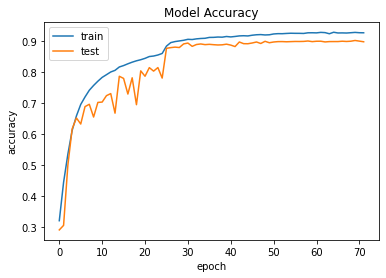

In [24]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(training_log['accuracy'])
plt.plot(training_log['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

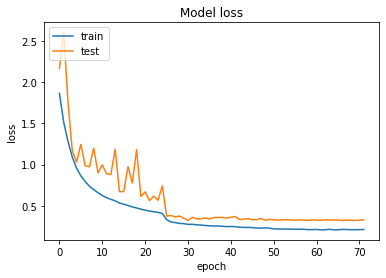

In [25]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(training_log['loss'])
plt.plot(training_log['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'],loc='upper left')
plt.show()

## 3. Conclusion

In [1]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ['Growth Rate','Compression','# of Blocks','Test Accuracy']
x.add_row([36,0.7,12,90.149])

print(x)

+-------------+-------------+-------------+---------------+
| Growth Rate | Compression | # of Blocks | Test Accuracy |
+-------------+-------------+-------------+---------------+
|      36     |     0.7     |      12     |     90.149    |
+-------------+-------------+-------------+---------------+


__*Summary:*__

I have used Keras callbacks to adjust the learning rate as per the performance of the model(ReduceLRonPlateau,LearningRate Sceduler).


**Additional links and resuorces:**

1.	2016 DenseNet paper summary: https://www.youtube.com/watch?v=hSC_0S8Zf9s
2. 	Separable Depth wise convolutions: https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
3. Review DenseNet image classification: https://towardsdatascience.com/review-densenet-image-classification-b6631a8ef803